In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy.io import loadmat
from scipy.optimize import curve_fit

import itertools

# 1. Import and Plot Data

In [29]:
def get_data(filename, measurement='amp'):
    data1 = loadmat(filename)
    transAmpData1 = data1['transamp']
    transPhaseData1 = data1['transphase']
    transFreqData1 = data1['transfreq']

    volts1 = data1['voltage_vector']

    Ylist = transFreqData1
    Xlist = volts1

    Xlist = np.asarray(Xlist)
    Ylist = np.asarray(Ylist)*1e-9

    # Xlist = (Xlist - voltOffSet +VoltPerFlux*center)/VoltPerFlux

    X,Y = np.meshgrid(Xlist,Ylist)

    ### make copies of spec data 
    phase = transPhaseData1.copy()
    amp = transAmpData1.copy()

#     ### remove average for better plotting
#     for i in range(0, len(phase[:,1]) ):
#         phase[i,:] = phase[i,:] - np.mean(phase[i,:])
#         amp[i,:] = amp[i,:] - np.mean(amp[i,:])
    
    if measurement == 'amp':
        Z = amp.copy()
    elif measurement == 'phase':
        Z = phase.copy()
    Z = np.asarray(Z)
    Z = np.transpose(Z)
    
    return(X, Y, Z)

In [49]:
def plot_spec_data(voltage_data, frequency_data, transmission_data, qubit_name=None, fit_voltages=None, fit_frequencies=None, vmin=-2, vmax=10):
    

    # Initialize the plot
    plt.figure()


    # To store axis limits
    voltage_min_all = float('inf')
    voltage_max_all = float('-inf')
    frequency_min_all = float('inf')
    frequency_max_all = float('-inf')

    for i in range(len(transmission_data)):
        voltage_min = voltage_data[i][0, 0]
        voltage_max = voltage_data[i][0, -1]
        voltage_step = voltage_data[i][0, 1] - voltage_data[i][0, 0]

        frequency_min = frequency_data[i][0, 0]
        frequency_max = frequency_data[i][-1, 0]
        frequency_step = frequency_data[i][1, 0] - frequency_data[i][0, 0]

        extent = (voltage_min - voltage_step / 2, 
                  voltage_max + voltage_step / 2, 
                  frequency_min - frequency_step / 2, 
                  frequency_max + frequency_step / 2)

        plt.imshow(transmission_data[i], interpolation='none', vmin=vmin, vmax=vmax, origin='lower', cmap='summer', aspect='auto', extent=extent, alpha=0.7)


        # Update the overall min/max for voltage and frequency
        voltage_min_all = min(voltage_min_all, extent[0])
        voltage_max_all = max(voltage_max_all, extent[1])
        frequency_min_all = min(frequency_min_all, extent[2])
        frequency_max_all = max(frequency_max_all, extent[3])

    # Set the overall axis limits
    plt.xlim(voltage_min_all, voltage_max_all)
    plt.ylim(frequency_min_all, frequency_max_all)

    if fit_frequencies is not None and fit_voltages is not None:
        plt.plot(fit_voltages, fit_frequencies, marker='o',linestyle='', color='red', ms=2)
        
    
    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (MHz)')
    plt.colorbar(label='Transmission (a.u.)')
    
    title = 'Qubit frequency vs voltage'
    if qubit_name is not None:
        title = f'{qubit_name} frequency vs voltage'
    plt.title(title)
    plt.show()


In [44]:
def generate_filename(datecode, timecode, file_name_start=None):
    if file_name_start is None:
        file_name_start = '2Tone5Qubit_Tri'
    return r'V:\QSimMeasurements\Measurements\5QV1_Triangle_Lattice\pnax{}24\{}_2024{}_{}'.format(datecode, file_name_start, datecode, timecode)

In [77]:
print(generate_filename('0923', '1740', file_name_start='2Tone4Qubit_NR'))

V:\QSimMeasurements\Measurements\5QV1_Triangle_Lattice\pnax092324\2Tone4Qubit_NR_20240923_1740


In [68]:
qubit_to_filename = {}

qubit_to_filename['Q1'] = generate_filename('0923', '1740', file_name_start='2Tone4Qubit_NR')


qubit_to_row_index = {}

qubit_to_row_index['Q1'] = 45

In [46]:
qubit_to_voltage_data = {}
qubit_to_frequency_data = {}
qubit_to_transmission_data = {}

In [47]:
all_qubits = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

for qubit in qubit_to_filename:
    
    voltage_data_all = []
    frequency_data_all = []
    transmission_data_all = []
    
    X, Y, Z = get_data(qubit_to_filename[qubit])

    voltage_data = np.array(X)
    frequency_data = np.array(Y)
    transmission_data = np.array(Z)
        
    qubit_to_voltage_data[qubit] = voltage_data
    qubit_to_frequency_data[qubit] = frequency_data    
    qubit_to_transmission_data[qubit] = transmission_data    

    

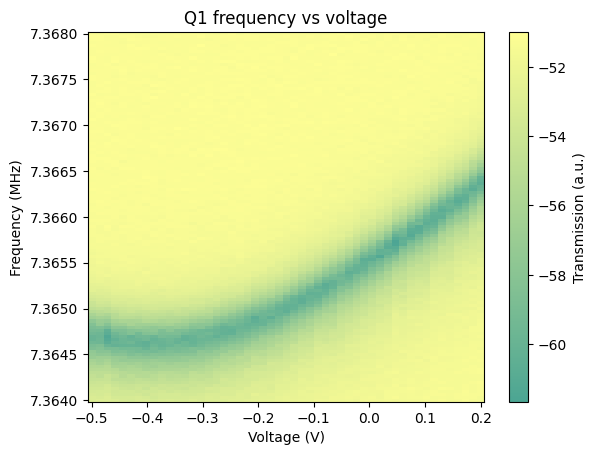

In [52]:
plot_qubits = ['Q1']

for qubit in plot_qubits:
    voltage_data = qubit_to_voltage_data[qubit]
    frequency_data = qubit_to_frequency_data[qubit]
    transmission_data = qubit_to_transmission_data[qubit]
    
    plot_spec_data([voltage_data], [frequency_data], [transmission_data], qubit_name=qubit, vmin=None, vmax=None)

# 2. Resonator Fit

In [121]:
def resonator_fit_model(x, x0, Q_tot, Q_ext, asymmetry, offset):
    '''
    assume x, x0 is frequency in GHz, convert to Hz
    '''
    
    x_Hz = x*1e9
    x0_Hz = x0*1e9
    
    return 20*np.log10(np.abs((1 - (Q_tot/Q_ext - 2j * Q_tot * asymmetry/(x0_Hz*2*np.pi)) / (1 + 2j*Q_tot*(x_Hz - x0_Hz)/x0_Hz) ))) + offset

In [ ]:
Center = 7.6814583333e+09
Qtot = 2.8624470131e+03
Qext = 4.1563052498e+03
Qint = 9.1951368471e+03
kappa (MHz) = 1.8481458583e+00
Assymmetry = 6.7875032849e+04
Offset = -5.3626306033e+01

In [ ]:
Center = 7.3659666667e+09
Qtot = 8.2696847259e+03
Qext = 1.2378116693e+04
Qint = 2.4915374863e+04
kappa (MHz) = 5.9507975645e-01
Assymmetry = 2.9741205099e+05
Offset = -5.1158205848e+01

In [66]:
print(qubit_to_frequency_data['Q1'].shape)
print(qubit_to_transmission_data['Q1'].shape)

(121, 51)
(121, 51)


### 2.1 Fit Data

In [99]:
qubit_to_popt = {}

C:\Users\mattm\OneDrive\Desktop\Research\Software\venv\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


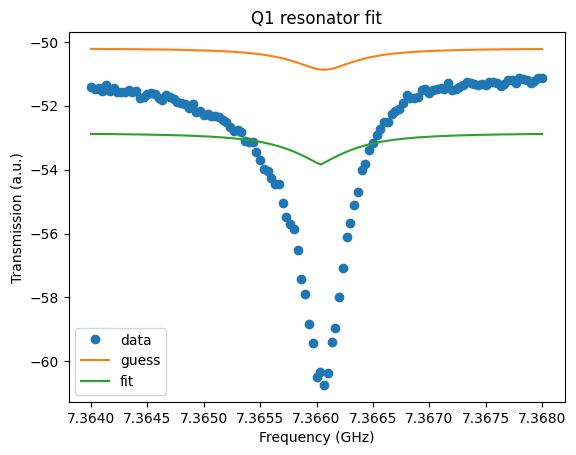

[ 7.36603418e+00 -7.13850772e+03 -7.15100334e+03  2.76098133e-03
 -5.38508796e+01]


In [120]:
fit_qubits = ['Q1']

for qubit in fit_qubits:
    
    voltage_data = qubit_to_voltage_data[qubit]
    frequency_data = qubit_to_frequency_data[qubit]
    transmission_data = qubit_to_transmission_data[qubit]
    
    row_index = qubit_to_row_index[qubit]

    frequency_slice = frequency_data[:,row_index]
    transmission_slice = transmission_data[:,row_index]

    # x0, Q_tot, Q_ext, asymmetry, offset
    initial_guess = [8.27e3, 1.23e4, 2.97e-4, 7.366, -5.12e1]
    initial_guess = [7.366, 8.27e3, 1.23e4, 2.97e-4, -5.12e1]
    
    min_index = np.argmin(transmission_slice)
    center_frequency_guess = frequency_slice[min_index]
    initial_guess = [center_frequency_guess, 1e3, 1e4, 1e-4, -50]
    initial_guess = [center_frequency_guess, 8.27e3, 1.23e4, 2.97e-4, -5.12e1]
    
    fit_frequencies = np.linspace(frequency_slice[0], frequency_slice[-1], 101)
    
    plt.plot(frequency_slice, transmission_slice, marker='o', linestyle='', label='data')
    plt.plot(fit_frequencies, resonator_fit_model(fit_frequencies, *initial_guess), label='guess')   
    
    popt, pcov = curve_fit(resonator_fit_model, frequency_slice, transmission_slice, p0=initial_guess)
    plt.plot(fit_frequencies, resonator_fit_model(fit_frequencies, *popt), label='fit')   
    
    qubit_to_popt[qubit] = popt
    
    
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('Transmission (a.u.)')
    
    plt.legend()
    plt.title(f'{qubit} resonator fit')
    plt.show()
    
    print(popt)

### 2.2 Extract Parameters

In [111]:
for qubit in qubit_to_popt:
    
    frequency, Q_tot, Q_ext, asymmetry, offset = qubit_to_popt[qubit]
    
    Q_int = 1/(1/Q_tot + 1/Q_ext)
    
    kappa = frequency/Q_ext
    kappa_MHz = kappa*1e3
    
    print(f'\n{qubit}:')
    print(f'\tFrequency: {np.round(frequency, 3)} GHz')
    print(f'\tkappa: {np.round(kappa_MHz, 3)} MHz')    
    print(f'\tQ tot: {np.round(Q_tot, 3)}')    
    print(f'\tQ ext: {np.round(Q_ext, 3)}')    
    print(f'\tQ int: {np.round(Q_int, 3)}')    
    


Q1:
	Frequency: 7.366 GHz
	kappa: 0.573 MHz
	Q tot: 8458.717
	Q ext: 12848.214
	Q int: 5100.66
